# Cross-Validation & Regularization

In [1]:
from sklearn.datasets import load_diabetes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['y'] = diabetes.target
sdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'y'],
                            outputCol='features')
dataset = assembler.transform(sdf)
dataset.show(5)

+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|                 age|               sex|                bmi|                  bp|                  s1|                 s2|                 s3|                  s4|                 s5|                 s6|    y|            features|
+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|  0.0380759064334241|0.0506801187398187| 0.0616962065186885|  0.0218723549949558| -0.0442234984244464|-0.0348207628376986|-0.0434008456520269|-0.00259226199818282| 0.0199084208763183|-0.0176461251598052|151.0|[0.03807590643342...|
|-0.00188201652779104|-0.044641636506989|-0.0514740612388061| -0.0263278

## We haven't tested models on unseen data!

In [3]:
train, test = dataset.randomSplit([0.5, 0.5])
lr = LinearRegression(featuresCol='features', labelCol='y')
model = lr.fit(train)

# Evaluate on training data
summary_train = model.evaluate(train)
print('R2 (training): ', summary_train.r2)

# Evaluate on training data
summary_test = model.evaluate(test)
print('R2 (testing): ', summary_test.r2)

R2 (training):  0.5458409627560749
R2 (testing):  0.4801422476078677


## Increase training fraction?

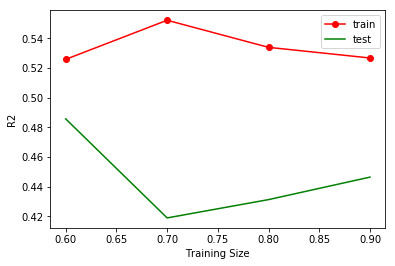

In [6]:
p_train = [0.6, 0.7, 0.8, 0.9]
train_r2 = []
test_r2 = []

for p in p_train:
    train, test = dataset.randomSplit([p, 1 - p])
    model = lr.fit(train)
    
    # Evaluate on training data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)

    # Evaluate on training data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

plt.plot(p_train, train_r2, 'ro-', label='train')
plt.plot(p_train, test_r2, 'g', label='test')
plt.xlabel('Training Size')
plt.ylabel('R2')
plt.legend()

## Question: How do we interpret this chart?

# Regularization for solving Ill-conditioned problems

## L2 Regularization:

$$ \mathbf{E(\mathbf{\beta})} = SSE(\mathbf{\beta}) + \frac{\lambda}{2}\|\mathbf{\beta}\|_{2}^{2}$$


### The _L2_ norm of a vector $\mathbf{x}$ is denoted as $\|\mathbf{x}\|^{2}_{2}$ (aka the _Euclidean_ or _Frobenius_ norm)

## L1 Regularization (aka Lasso):

$$ \mathbf{E(\mathbf{\beta})} = SSE(\mathbf{\beta}) + \lambda\|\mathbf{\beta}\|_{1}$$


### The _L1_ norm of a vector $\mathbf{x}$ is denoted as $\|\mathbf{x}\|_{1}$ (aka the _Taxicab_ or _Manhattan_ norm)

---

## ElasticNet Regularization (Combining L1 and L2)

$$ \mathbf{E(\mathbf{\beta})} = SSE(\mathbf{\beta}) + \lambda\left[\frac{1}{2}(1 - \alpha)\|\mathbf{\beta}\|_{2}^{2} + \alpha\|\mathbf{\beta}\|_{1}\right]$$


**Note**: In MLlib models, `elasticNetParam` corresponds to $\alpha$ and `regParam` corresponds to $\lambda$, therefore:
  * For using L2 regularization set `elasticNetParam = 0` and `regParam > 0`
  * For using L1 regularization set `elasticNetParam = 1` and `regParam > 0`
  * For using ElasticNet, set both to a nonzero value

### Using L2 regularization on the Diabetes dataset

In [9]:
train, test = dataset.randomSplit([0.7, 0.3])
lr = LinearRegression(featuresCol='features', labelCol='y', elasticNetParam=0, regParam=1)
model = lr.fit(train)

# Evaluate on training data
summary_train = model.evaluate(train)
print('R2 (training): ', summary_train.r2)

# Evaluate on training data
summary_test = model.evaluate(test)
print('R2 (testing): ', summary_test.r2)

R2 (training):  0.5162697284908986
R2 (testing):  0.5043453419682258


## Choosing the right value of $\lambda$

In [10]:
valid_lambdas = np.logspace(-1, 1, 20)

In [11]:
valid_lambdas

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

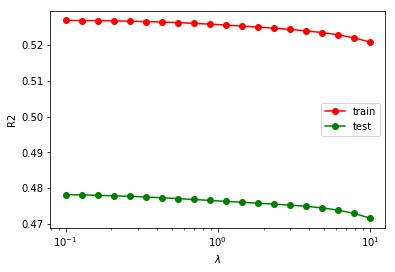

In [12]:
train_r2 = []
test_r2 = []
train, test = dataset.randomSplit([0.7, 0.3])

for l in valid_lambdas:    
    lr = LinearRegression(featuresCol='features', labelCol='y', elasticNetParam=0, regParam=l)
    model = lr.fit(train)

    # Evaluate on training data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)

    # Evaluate on training data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

    
plt.plot(valid_lambdas, train_r2, 'ro-', label='train')
plt.plot(valid_lambdas, test_r2, 'go-', label='test')
plt.xlabel('$\lambda$')
plt.ylabel('R2')
plt.xscale('log')
plt.legend()

### Exercise: Extend the search for $\lambda$ further, by inspecting more values. (already provided)

In [13]:
valid_lambdas = np.logspace(0, 2, 20)

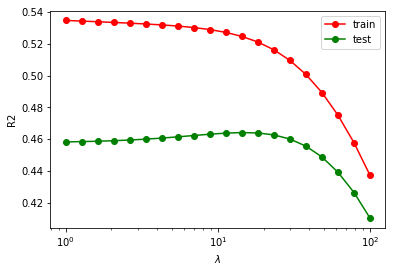

In [14]:
train_r2 = []
test_r2 = []
train, test = dataset.randomSplit([0.7, 0.3])

for l in valid_lambdas:    
    lr = LinearRegression(featuresCol='features', labelCol='y', elasticNetParam=0, regParam=l)
    model = lr.fit(train)

    # Evaluate on training data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)

    # Evaluate on training data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

    
plt.plot(valid_lambdas, train_r2, 'ro-', label='train')
plt.plot(valid_lambdas, test_r2, 'go-', label='test')
plt.xlabel('$\lambda$')
plt.ylabel('R2')
plt.xscale('log')
plt.legend()

## Using L1 Regularization

In [15]:
train, test = dataset.randomSplit([0.7, 0.3])
lr = LinearRegression(featuresCol='features', labelCol='y', elasticNetParam=1, regParam=0.3)
model = lr.fit(train)

# Evaluate on training data
summary_train = model.evaluate(train)
print('R2 (training): ', summary_train.r2)

# Evaluate on training data
summary_test = model.evaluate(test)
print('R2 (testing): ', summary_test.r2)

R2 (training):  0.5248937842866118
R2 (testing):  0.4714199030214574


### Choosing the right value of $\lambda$ for L1

In [18]:
valid_lambdas = np.linspace(0, 10, 20)

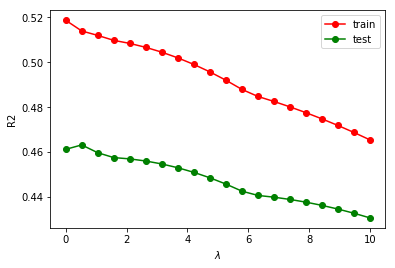

In [19]:
train_r2 = []
test_r2 = []
train, test = dataset.randomSplit([0.7, 0.3])

for l in valid_lambdas:    
    lr = LinearRegression(featuresCol='features', labelCol='y', elasticNetParam=1, regParam=l)
    model = lr.fit(train)

    # Evaluate on training data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)

    # Evaluate on training data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

    
plt.plot(valid_lambdas, train_r2, 'ro-', label='train')
plt.plot(valid_lambdas, test_r2, 'go-', label='test')
plt.xlabel('$\lambda$')
plt.ylabel('R2')
#plt.xscale('log')
plt.legend()

### Sparsity from the L1 Norm

In [22]:
# Fit the model
l = 5
lr = LinearRegression(featuresCol='features', labelCol='y', elasticNetParam=1, regParam=l)
model = lr.fit(dataset)

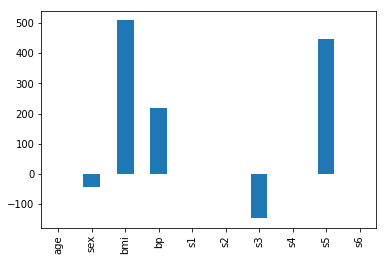

In [23]:
# See coefficients
pd.Series(np.array(model.coefficients), index=assembler.getInputCols()).plot(kind='bar')